# Inversión electromagnética transitoria

Importar las librerías

In [1]:
import numpy as np
from simpeg import maps
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from scipy.constants import mu_0
from discretize import TensorMesh

from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import utils, data
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# MT
from simpeg.electromagnetics import natural_source as nsem

# TDEM
import os
import pygimli as pg
from pygimli.physics import em
import simpeg.electromagnetics.time_domain as tdem
from simpeg.electromagnetics.static import resistivity as dc

mpl.rcParams.update({"font.size": 16})
write_output = False

In [2]:
# Cargar el archivo
Datos_SEV = np.load("../FASE 1/SEV/DatosSEV.npy", allow_pickle=True).item()

# Extraer las variables
dobsSEV = Datos_SEV["dpredSEV"]
ab2  = Datos_SEV["ab2"]

# Cargar el archivo
Datos_SEDT = np.load("../FASE 1/SEV/DatosSEDTdbdt.npy", allow_pickle=True).item()

# Extraer las variables
dobsTDEM = Datos_SEDT["dobsTDEM"]
times = Datos_SEDT["times"]

# Cargar el archivo
Datos_SEDT_rhoa = np.load("../FASE 1/SEV/DatosSEDTrhoa.npy", allow_pickle=True).item()

# Extraer las variables
dobsSEDT_rhoa = Datos_SEDT_rhoa["dobsTDEM"]
timess  = Datos_SEDT_rhoa["times"]

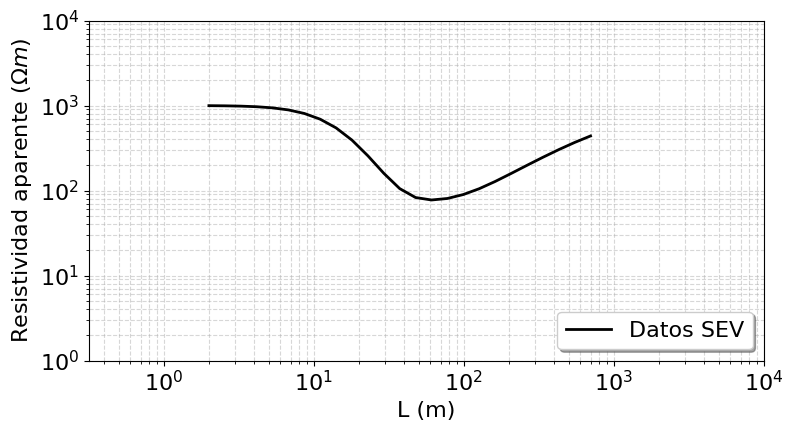

In [3]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])

#ax.loglog(L, rhoa_TDEM, "blue",  label='Datos SEDT', lw=2)
ax.loglog(ab2, 5*dobsSEV, "black", label='Datos SEV', lw=2)

ax.set_xlabel("L (m)")
ax.set_ylabel("Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**4])
ax.set_xlim([10**-0.5, 10**4])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

plt.show()

In [4]:
dpred_LM = dobsTDEM[25:]
dpred_HM = dobsTDEM[:25]

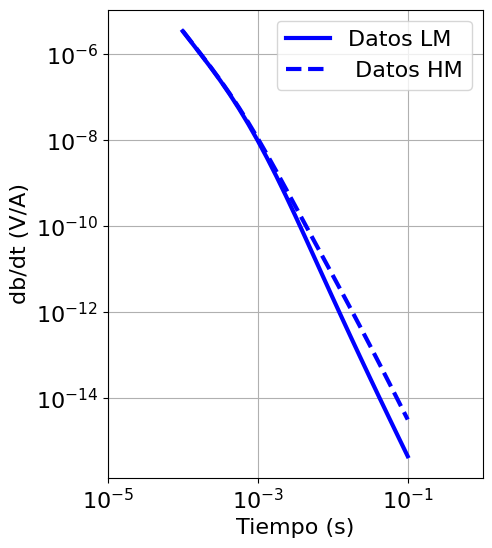

In [5]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, -dpred_LM, "b-", lw=3, label='Datos LM')
ax.loglog(times, -dpred_HM, "b--", lw=3, label=' Datos HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("db/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

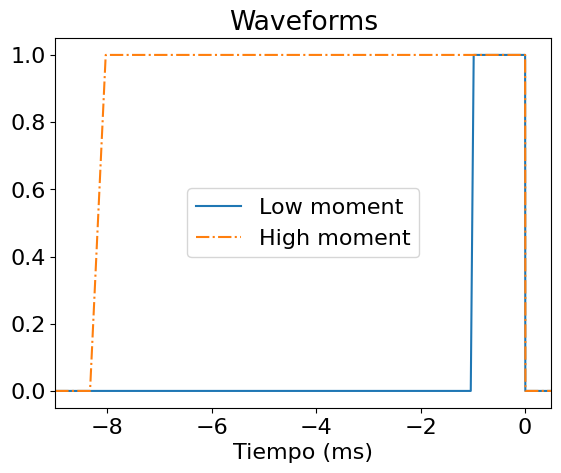

In [6]:
# Definir waveform

# Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Tiempo (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

waveform_LM = tdem.sources.PiecewiseLinearWaveform(
    times=lm_waveform_times, currents=lm_waveform_current
)

waveform_HM = tdem.sources.PiecewiseLinearWaveform(
    times=hm_waveform_times, currents=hm_waveform_current
)

# Receptores

receiver_location = np.array([0, 0, 0])
receiver_orientation = "z"  # "x", "y" or "z"

times = np.logspace(-4,-1,25)

receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Fuente

source_location = np.array([
    [-20, -20, 0],        # Vértice 1 (punto de inicio)
    [20, -20, 0],     # Vértice 2
    [20, 20, 0],  # Vértice 3
    [-20, 20, 0],     # Vértice 4
    [-20, -20, 0]         # Cerrar el bucle (vuelve al punto de inicio)
])

source_list = [tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_HM,),

        tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_LM,)
]

# Definir el arreglo
surveyTDEM = tdem.Survey(source_list)

In [7]:
#Asignar incertidumbres y definir datos
uncertainties = 0.01 * np.abs(dobsTDEM) * np.ones(np.shape(dobsTDEM))
data_object = data.Data(surveyTDEM, dobs=dobsTDEM, standard_deviation=uncertainties)

In [8]:
#Definir la malla

# Definir los espesores de las capas
layer_thicknesses = np.logspace(0, 1.97,10)

# Definir las celdas activas
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Crear la regularización
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)

n_layers = len(layer_thicknesses) + 1  # Numero de capas


  TensorMesh: 11 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     11       -327.53         -0.00      1.00     93.33    1.66




In [9]:
# Definir un modelo inicial. Resistividad (Ohm metro) o conductividad (S/m) para cada capa
starting_model = np.log(200 * np.ones(n_layers))

# Definir la correspondencia entre el modelo y las celdas activas
model_map = maps.ExpMap(nP=n_layers)

reference_resistivity_model = starting_model.copy()

In [10]:
# Definir la física
simulation = tdem.Simulation1DLayered(
    survey=surveyTDEM,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [11]:
# Definir el desajuste de los datos
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Definir la regularización
reg = regularization.Sparse(
    regularization_mesh, reference_model=starting_model, alpha_s=1.0, alpha_x=1.0
)


#Definir la optimización
opt = optimization.InexactGaussNewton(maxIter=50, maxIterCG=30)

#Definir el problema inverso
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [12]:
# Definir las directivas de inversión
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=3.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1)

directives_list = [update_jacobi, starting_beta, beta_schedule, target_misfit]

In [13]:
# Combinar el problema inverso y las directivas
inv = inversion.BaseInversion(inv_prob, directives_list)

# Ejecutar la inversión
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


C:\Users\DANIELA\anaconda3\envs\simpeg0230v3\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.88e+02  4.33e+05  0.00e+00  4.33e+05    6.31e+04      0              
   1  2.88e+02  2.77e+05  5.62e+00  2.78e+05    1.01e+05      2              
   2  9.61e+01  1.94e+05  2.15e+01  1.96e+05    7.36e+04      2              
   3  9.61e+01  1.73e+05  6.44e+01  1.80e+05    4.14e+05      2              
   4  3.20e+01  1.14e+05  5.27e+01  1.15e+05    5.67e+04      0              
   5  3.20e+01  1.03e+05  5.97e+01  1.04e+05    8.40e+04      4              
   6  1.07e+01  1.02e+05  6.80e+01  1.03e+05    2.19e+05      3   Skip BFGS  
   7  1.07e+01  9.31e+04  8.77e+01  9.41e+04    2.30e+05      3              
   8  3.56e+00  8.76e+04  1.80e+02  8.82e+04    3.70e+05      2   Skip BFGS  
   9  3.56e+00  4.46e+04

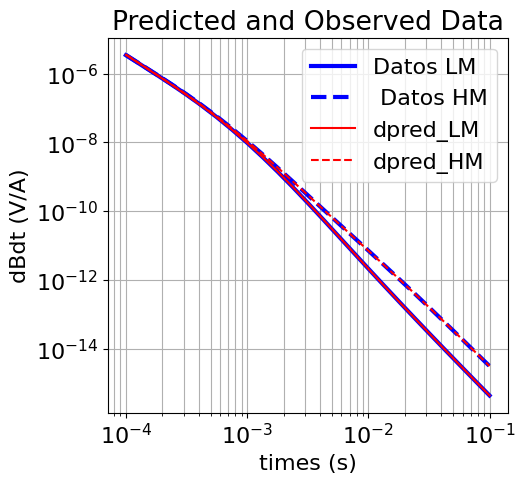

In [14]:
dpred = simulation.dpred(recovered_model)


fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])

ax1.loglog(times, -dpred_LM, "b-", lw=3, label='Datos LM')
ax1.loglog(times, -dpred_HM, "b--", lw=3, label=' Datos HM')

ax1.loglog(times, -dpred[25:], "r-", label='dpred_LM')
ax1.loglog(times, -dpred[:25], "r--", label='dpred_HM')

ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("dBdt (V/A)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(loc="upper right")
plt.show()

In [15]:
dpredLM = dpred[25:]
dpredHM = dpred[:25]

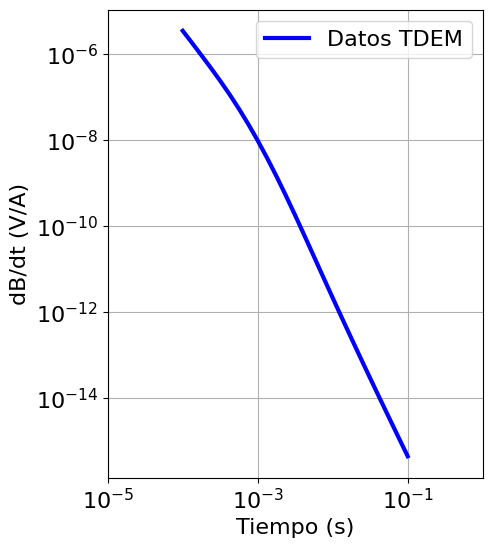

In [16]:
from scipy import interpolate
x = np.concatenate((times, times))
y = np.concatenate((-dpredHM, -dpredLM))
f = interpolate.interp1d(x, y)

times_ok = np.logspace(np.log10(np.min(times)),np.log10(np.max(times)),25)
dpredTDEM_ok = f(times_ok)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times_ok, dpredTDEM_ok, "b-", lw=3, label='Datos TDEM')
#ax.loglog(xnew, ynew, "r--", lw=3, label='dpred_HM')
#ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
#ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("dB/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [17]:
from pygimli.physics.em import rhoafromU

In [18]:
rhoa_TDEM = rhoafromU(U= dpredTDEM_ok, t= times_ok, Tx= 1600, Rx= 1)

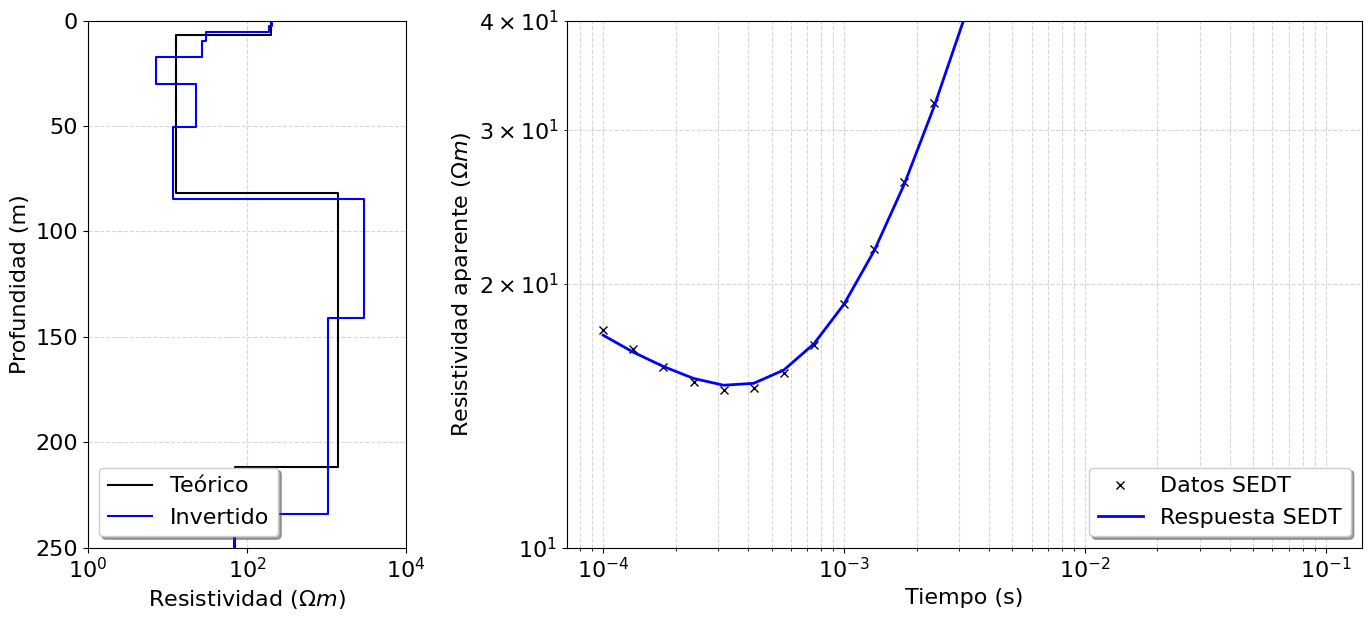

In [19]:
import matplotlib.gridspec as gridspec


# Definir espesores de las capas
true_thicknesses = np.r_[7, 75, 130]

# Definir resistividades de las capas
true_resistivities = np.r_[200, 13, 1400, 70]

# Crear figura y configurar GridSpec
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.8, 2], height_ratios=[1, 1])

# Primer subplot (izquierda) - Modelo
ax1 = fig.add_subplot(gs[0])
plot_1d_layer_model(true_thicknesses, true_resistivities, ax=ax1, color="k", label="Teórico")
plot_1d_layer_model(
    layer_thicknesses, (model_map * recovered_model), ax=ax1, color="b", label="Invertido"
)

ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel(r"Profundidad (m)")
ax1.set_xlim(1e0, 1e4)
ax1.set_ylim([250, 0])
ax1.legend(loc='lower left', frameon=True, shadow=True, fancybox=True)

# Segundo subplot (derecha) - Datos
ax2 = fig.add_subplot(gs[1])
ax2.loglog(timess, dobsSEDT_rhoa, "kx", lw=2, label='Datos SEDT')
ax2.loglog(times_ok, rhoa_TDEM, "b-", lw=2, label='Respuesta SEDT')
ax2.set_xlabel("Tiempo (s)") 
ax2.set_ylabel(r"Resistividad aparente ($\Omega m$)")
#ax2.set_xlim(1e0, 1e4)
ax2.set_ylim([10*1, 10*4])
ax2.grid(True, which="both", linestyle='--', alpha=0.5)
ax2.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

#plt.savefig("inversion_electromagnetica.png", dpi=300, bbox_inches='tight', format='png')

# Ajustar espacio entre subplots
plt.tight_layout()
plt.show()

In [20]:
model_map * recovered_model

array([ 199.34325274,  204.60877526,  187.808324  ,   30.29043938,
         27.31712313,    7.21234688,   22.95065662,   11.82941275,
       2937.49232394, 1058.68773934,   68.50387483])

In [21]:
modelo = np.array([ 203.31670106,  208.53438211,  183.22120558,   28.71707897,
         27.40642554,    7.24859737,   23.03662235,   11.79492843,
       3481.03047233, 1041.39694993,   68.6020822 ])

In [22]:
# Convertir de tiempo a ab2
Ldpred = 711.8 * np.sqrt(times_ok * dpredTDEM_ok)
L = 711.8 * np.sqrt(timess * dobsSEDT_rhoa)


Respuesta SEV

In [23]:
# Arreglo tipo schlumberger

# Definir el espaciado de ab2 y número de sondeos
ab2= np.logspace(np.log10(2),np.log10(700),25) # Desde 1.5 metros a 200 metros

# Crear lista de las fuentes
source_list = []
for ii in range(0, len(ab2)):
    abb2 = ab2[ii]

    # Ubicación de los electrodos A y B
    A_location = np.r_[-abb2, 0.0, 0.0]
    B_location = np.r_[abb2, 0.0, 0.0]

    # Ubicación de los electrodos M y N
    M_location = np.r_[-abb2/3, 0.0, 0.0]
    N_location = np.r_[abb2/3, 0.0, 0.0]

    # Crear lista de receptores
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Definir las propiedades de las fuentes y receptores asociados
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Definir el arreglo
surveySEV = dc.Survey(source_list)

In [24]:
# Modelo hidrogeológico

# Definir espesores de las capas
thicknesses = layer_thicknesses

# Definir resistividades de las capas
model = model_map * recovered_model

# Número de capas
n_layers = len(model)

# Definir mapeo del modelo de conductividad
resistivity_model = model.copy()
model_map = maps.IdentityMap(nP=n_layers)

In [25]:
simulationSEV = dc.simulation_1d.Simulation1DLayers(
    survey=surveySEV,
    rhoMap=model_map,
    thicknesses=thicknesses,
)

dpredSEV = simulationSEV.dpred(model)

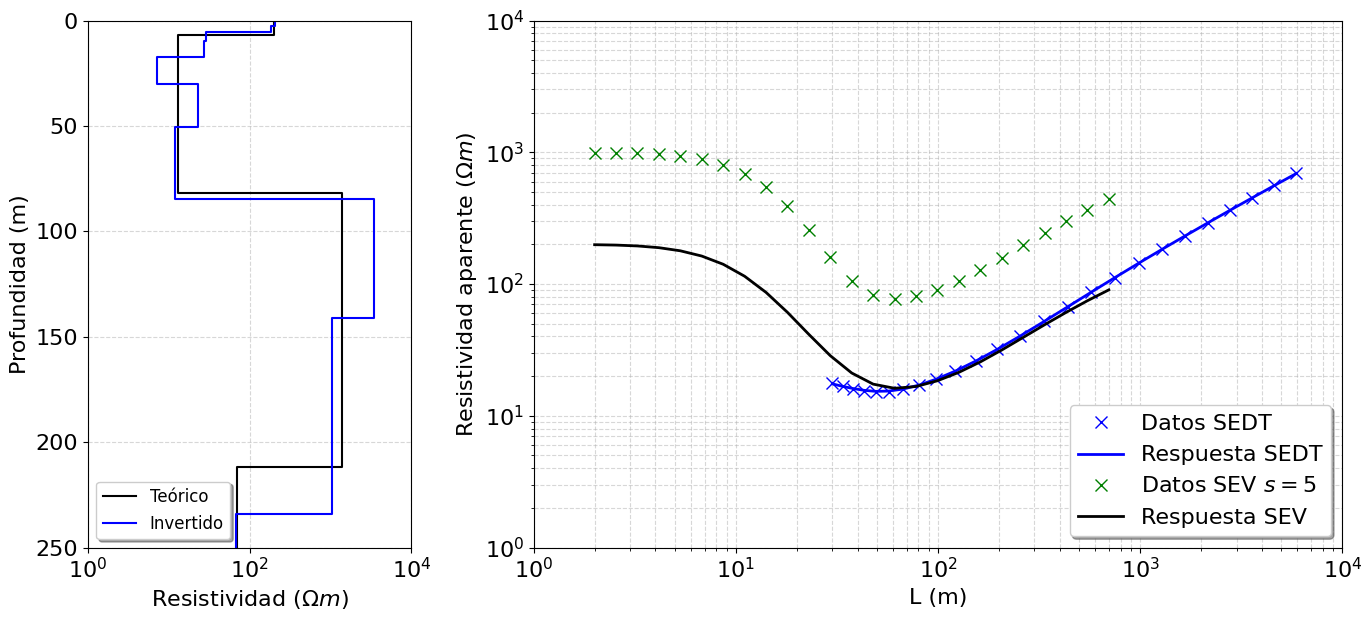

In [26]:
import matplotlib.gridspec as gridspec


# Definir espesores de las capas
true_thicknesses = np.r_[7, 75, 130]

# Definir resistividades de las capas
true_resistivities = np.r_[200, 13, 1400, 70]

# Crear figura y configurar GridSpec
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.8, 2], height_ratios=[1, 1])

# Primer subplot (izquierda) - Modelo
ax1 = fig.add_subplot(gs[0])
plot_1d_layer_model(true_thicknesses, true_resistivities, ax=ax1, color="k", label="Teórico")
plot_1d_layer_model(
    layer_thicknesses, (modelo), ax=ax1, color="b", label="Invertido"
)

ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel(r"Profundidad (m)")
ax1.set_xlim(1e0, 1e4)
ax1.set_ylim([250, 0])
ax1.legend(loc='lower left', frameon=True, shadow=True, fancybox=True, fontsize=12)

# Segundo subplot (derecha) - Datos
ax2 = fig.add_subplot(gs[1])
ax2.loglog(L, dobsSEDT_rhoa, "blue", marker = "x", markersize= 8, linestyle='none', label='Datos SEDT', lw=2)
ax2.loglog(L, rhoa_TDEM, "b-", lw=2, label='Respuesta SEDT')
ax2.loglog(ab2, (5*dobsSEV), "green", marker = "x", markersize= 8, linestyle='none', label='Datos SEV $\mathit{s}=5$', lw=2)
ax2.loglog(ab2, dpredSEV, "black", label='Respuesta SEV', lw=2)
ax2.set_xlabel("L (m)")
ax2.set_ylabel("Resistividad aparente ($\Omega m$)")
ax2.set_ylim([10**0, 10**4])
ax2.set_xlim([10**0, 10**4])
ax2.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)
# Ajustar espacio entre subplots
plt.tight_layout()
plt.savefig("inv_electro_sintetico.svg", dpi=300, bbox_inches='tight', format='svg')


plt.show()

In [27]:
# Calcular el desplazamiento estático

s = np.mean( (5*dobsSEV)[20:]/ dpredSEV[20:])

print(f"Desplazamiento s = {s:.3f}")

Desplazamiento s = 4.956


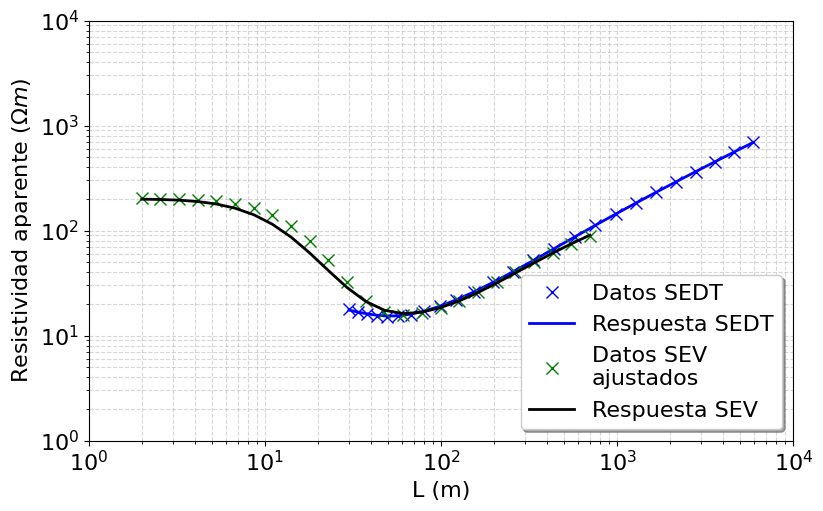

In [28]:
fig = plt.figure(figsize=(14, 12))
# Segundo subplot (derecha) - Datos
ax2 = fig.add_subplot(gs[1])
ax2.loglog(L, dobsSEDT_rhoa, "blue", marker = "x",markersize= 8,  linestyle='none', label='Datos SEDT', lw=2)
ax2.loglog(L, rhoa_TDEM, "b-", lw=2, label='Respuesta SEDT')
ax2.loglog(ab2, 0.2031281738777168*(5*dobsSEV), "green", marker = "x", markersize= 8, linestyle='none', label='Datos SEV \najustados', lw=2)
ax2.loglog(ab2, dpredSEV, "black", label='Respuesta SEV', lw=2)
ax2.set_xlabel("L (m)")
ax2.set_ylabel("Resistividad aparente ($\Omega m$)")
ax2.set_ylim([10**0, 10**4])
ax2.set_xlim([10**0, 10**4])
ax2.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)
plt.savefig("SEV_sint_ajustados.svg", dpi=300, bbox_inches='tight', format='svg')
plt.show()